<a href="https://colab.research.google.com/github/maaz1m/cross-view-image-retrieval/blob/main/Cross_View_Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-View Image Retrieval (CVIR)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=156SxdPcJCFqeZhhW7nBuLBWu3UkiyaKK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=156SxdPcJCFqeZhhW7nBuLBWu3UkiyaKK" -O DLAS4.zip && rm -rf /tmp/cookies.txt
!unzip -q DLAS4.zip

In [ ]:
# Set classes based on dataset
NUM_CLASSES = 6
labels_dict = {"freeway":0,"mountain":1,"palace":2,"river":3,"ship":4,"stadium":5}

# Set hyperparamaters
BATCH_SIZE = 32
EPOCHS = 5

In [ ]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU, Input, concatenate, add, Reshape, Conv2D, Activation
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import collections
import os
from scipy.spatial.distance import cosine
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImageDataGenerator
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1 Loading Data
We have loaded images from two different views: Street (Ground Level) and Satellite. Each of these views contain images of 6 classes: Freeway, Mountain, River, Ship, Stadium, and Palace. Here we will be using built-in Image Generators in TensorFlow. <br> 

### Using Built-In Data Generator
First, we will create ImageDataGenerator objects, which allows us to add methods to augment data in real-time as well as pre-process it.

In [ ]:
train_aug = ImageDataGenerator(
    validation_split = 0.2)

Now, we create data generators (Train and Validation for **EACH** view) using the flow_from_directory method of the ImageDataGenerator object.

In [ ]:
sat_train_gen = train_aug.flow_from_directory(
    'SatView/Images',
    target_size=(224, 224),
    subset='training'
)

sat_val_gen = train_aug.flow_from_directory(
    'SatView/Images',
    target_size=(224, 224),
    subset='validation'
)

str_train_gen = train_aug.flow_from_directory(
    'StreetView/Images',
    target_size=(224, 224),
    subset='training'
)

str_val_gen = train_aug.flow_from_directory(
    'StreetView/Images',
    target_size=(224, 224),
    subset='validation'
)

Found 3360 images belonging to 6 classes.
Found 840 images belonging to 6 classes.
Found 4271 images belonging to 6 classes.
Found 1064 images belonging to 6 classes.


## 2 Classification Models
In order to extract discriminative features, we will imply transfer learning and use VGG16 (pre-trained on ImageNet) models to fine-tune them for our purpose. These models will be used to perform image classification for images in each view. We will be training a separate model for each view.

### Create an Instance of a pre-trained VGG16 Model
We'll create an instance of a VGG16 model (pre-trained on Imagenet) that is available in the Keras Applications module.

In [ ]:
base_model_sat = VGG16(include_top=False, weights = 'imagenet', input_tensor=Input(shape=(224, 224, 3)))
base_model_str = VGG16(include_top=False, weights = 'imagenet', input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model_sat._name = "sat_base_model"
base_model_str._name = "str_base_model"

### Adding additional layers to fine-tune the model

In [ ]:
# Add layers to your Satellite Base Model
out_sat = base_model_sat.output
flat_sat = Flatten()(out_sat)
dense1_sat = Dense(1024,activation='relu')(flat_sat)
dropout1_sat = Dropout(0.4)(dense1_sat)
dense2_sat = Dense(1024,activation='relu')(dropout1_sat)
dropout2_sat = Dropout(0.4)(dense2_sat)
preds_sat = Dense(NUM_CLASSES,activation='softmax')(dropout2_sat)


In [ ]:
# Add layers to your Street Base Model
out_str = base_model_str.output
flat_str = Flatten()(out_str)
dense1_str = Dense(1024,activation='relu')(flat_str)
dropout1_str = Dropout(0.4)(dense1_str)
dense2_str = Dense(1024,activation='relu')(dropout1_str)
dropout2_str = Dropout(0.4)(dense2_str)
preds_str = Dense(NUM_CLASSES,activation='softmax')(dropout2_str)


Now, create new Models using the Model constructor

In [ ]:
sat_classification_model = Model(inputs=base_model_sat.input,outputs=preds_sat)
str_classification_model = Model(inputs=base_model_str.input,outputs=preds_str)

In [ ]:
sat_classification_model._name = 'sat_classification_model'
str_classification_model._name = 'str_classification_model'

View the model summary for each model and verify if your model is correct

In [ ]:
sat_classification_model.summary()

Model: "sat_classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56

In [ ]:
# Freeze layers for both models
for layer in sat_classification_model.layers[:-6]:
    layer.trainable=False
for layer in str_classification_model.layers[:-6]:
    layer.trainable=False


Now, we can compile our models.

In [ ]:
# Compile
sat_classification_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
str_classification_model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Classification Model

In [ ]:
# Callbacks for Satellite Model
if not os.path.exists('Models'):
    os.mkdir('Models/')


In [ ]:
# Callbacks for Street Model
if not os.path.exists('Models'):
    os.mkdir('Models/')


In [ ]:
# Load weights for both models
str_classification_model.load_weights('str_weights')
sat_classification_model.load_weights('sat_weights')

In [ ]:
sat_hist = sat_classification_model.fit_generator(generator=sat_train_gen,
                                       steps_per_epoch = sat_train_gen.n//BATCH_SIZE,
                                       validation_data = sat_val_gen,
                                       validation_steps = sat_val_gen.n//BATCH_SIZE,
                                       epochs = 2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
105/105 [==============================] - 12s 115ms/step - loss: 8.3693 - accuracy: 0.8018 - val_loss: 1.6998 - val_accuracy: 0.9075
Epoch 2/2
105/105 [==============================] - 12s 112ms/step - loss: 1.4509 - accuracy: 0.9149 - val_loss: 1.7915 - val_accuracy: 0.9087


In [ ]:
str_hist = str_classification_model.fit_generator(generator=str_train_gen,
                                       steps_per_epoch = str_train_gen.n//BATCH_SIZE,
                                       validation_data = str_val_gen,
                                       validation_steps = str_val_gen.n//BATCH_SIZE,
                                       epochs = 2)

Epoch 1/2
 58/133 [============>.................] - ETA: 3:11 - loss: 10.3029 - accuracy: 0.8481

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (122081580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


133/133 [==============================] - 432s 3s/step - loss: 7.1529 - accuracy: 0.8853 - val_loss: 1.5513 - val_accuracy: 0.9621
Epoch 2/2
133/133 [==============================] - 434s 3s/step - loss: 2.4847 - accuracy: 0.9516 - val_loss: 1.9743 - val_accuracy: 0.9583


### Model Analysis

Plotting losses and accuracies for both models.

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

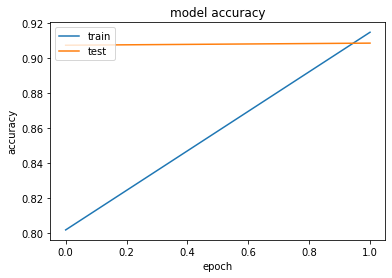

In [ ]:
plot_accuracy(sat_hist)

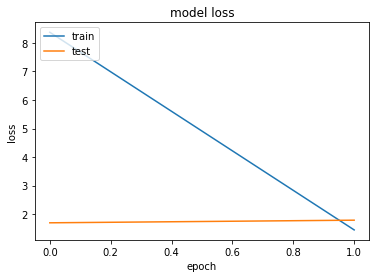

In [ ]:
plot_loss(sat_hist)

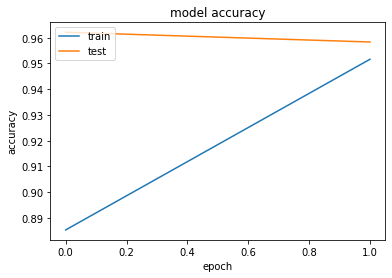

In [ ]:
plot_accuracy(str_hist)

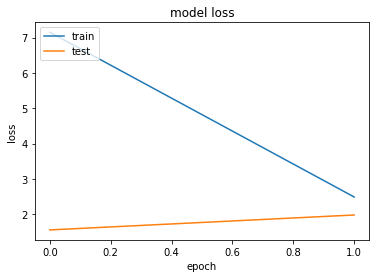

In [ ]:
plot_loss(str_hist)

Plotting a confusion matrix

In [ ]:
def plot_confusion_matrix(conf_mat):
    classes = ['freeway', 'mountain', 'palace', 'river', 'ship', 'stadium']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

Instructions for updating:
Please use Model.predict, which supports generators.


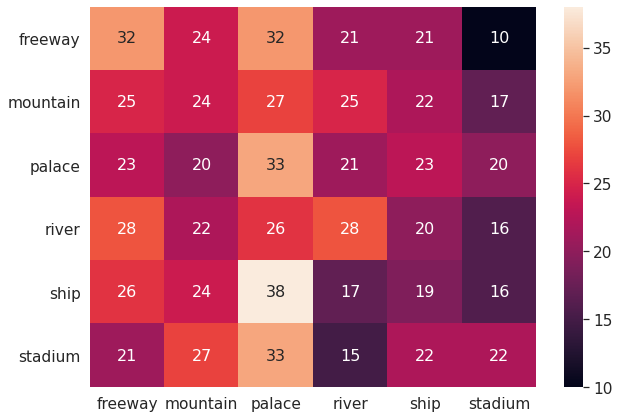

In [ ]:
Y_pred = sat_classification_model.predict_generator(sat_val_gen, sat_val_gen.n//BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
conf_mat = confusion_matrix(sat_val_gen.classes, y_pred)
plot_confusion_matrix(conf_mat)

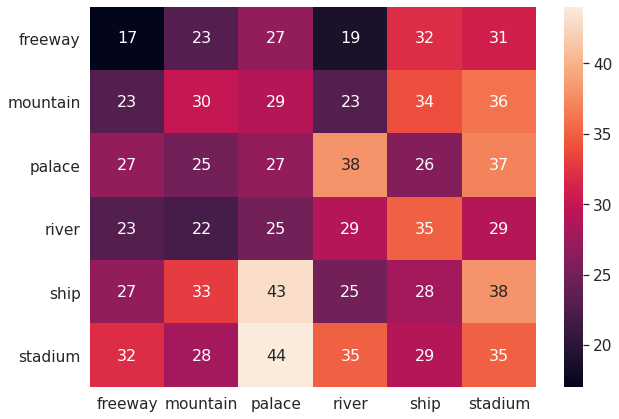

In [ ]:
Y_pred = str_classification_model.predict_generator(str_val_gen, str_val_gen.n//BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
conf_mat = confusion_matrix(str_val_gen.classes, y_pred)
plot_confusion_matrix(conf_mat)

## 3 Similarity Matching
This is the core of our CVIR system, where feature vectors of query images and search images will be compared and assigned a similarity score (or distance between these two vectors). We will be using the following distance metrics in order to compute similarity (distance is opposite of similarity,lower distance means more similar):

- Cosine
- DML

### Distance Metric Learning
Just like cosine, euclidean, and other metrics to compute distances between two feature vectors, we can create a Neural Network that can compute a distance metric for us given two input feature vectors.

#### Setting up the DML

In [ ]:
def DML():
    input1 = Input(shape=(1024,1))
    reshape1 = Reshape((32, 32, 1))(input1)
    input2 = Input(shape=(1024,1))
    reshape2 = Reshape((32, 32, 1))(input2)
    concat = concatenate([reshape1, reshape2])
    conv1 = Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation = 'relu')(concat)
    conv2 = Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation = 'relu')(conv1)
    conv3 = Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation = 'relu')(conv2)
    add1 = add([conv3, conv1])
    conv4 = Conv2D(filters = 16, kernel_size=(3,3), strides = 2, padding='same', activation = 'relu')(add1)
    conv5 = Conv2D(filters = 16, kernel_size=(3,3), strides = 2, padding='same', activation = 'relu')(add1)
    conv6 = Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation = 'relu')(conv4)
    add2 = add([conv6, conv5])
    lrelu1 = LeakyReLU(0.3)(add2)
    flatten1 = Flatten()(lrelu1)
    dense1 = Dense(1024)(flatten1)
    lrelu2 = LeakyReLU(0.3)(dense1)
    dense2 = Dense(512)(lrelu2)
    lrelu3 = LeakyReLU(0.3)(dense2)
    dense3 = Dense(64)(lrelu3)
    lrelu4 = LeakyReLU(0.3)(dense3)
    dense4 = Dense(1)(lrelu4)
    acti = Activation(activation='sigmoid')(dense4)
    model = Model(inputs=[input1, input2], outputs=acti)
    model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
dml = DML()

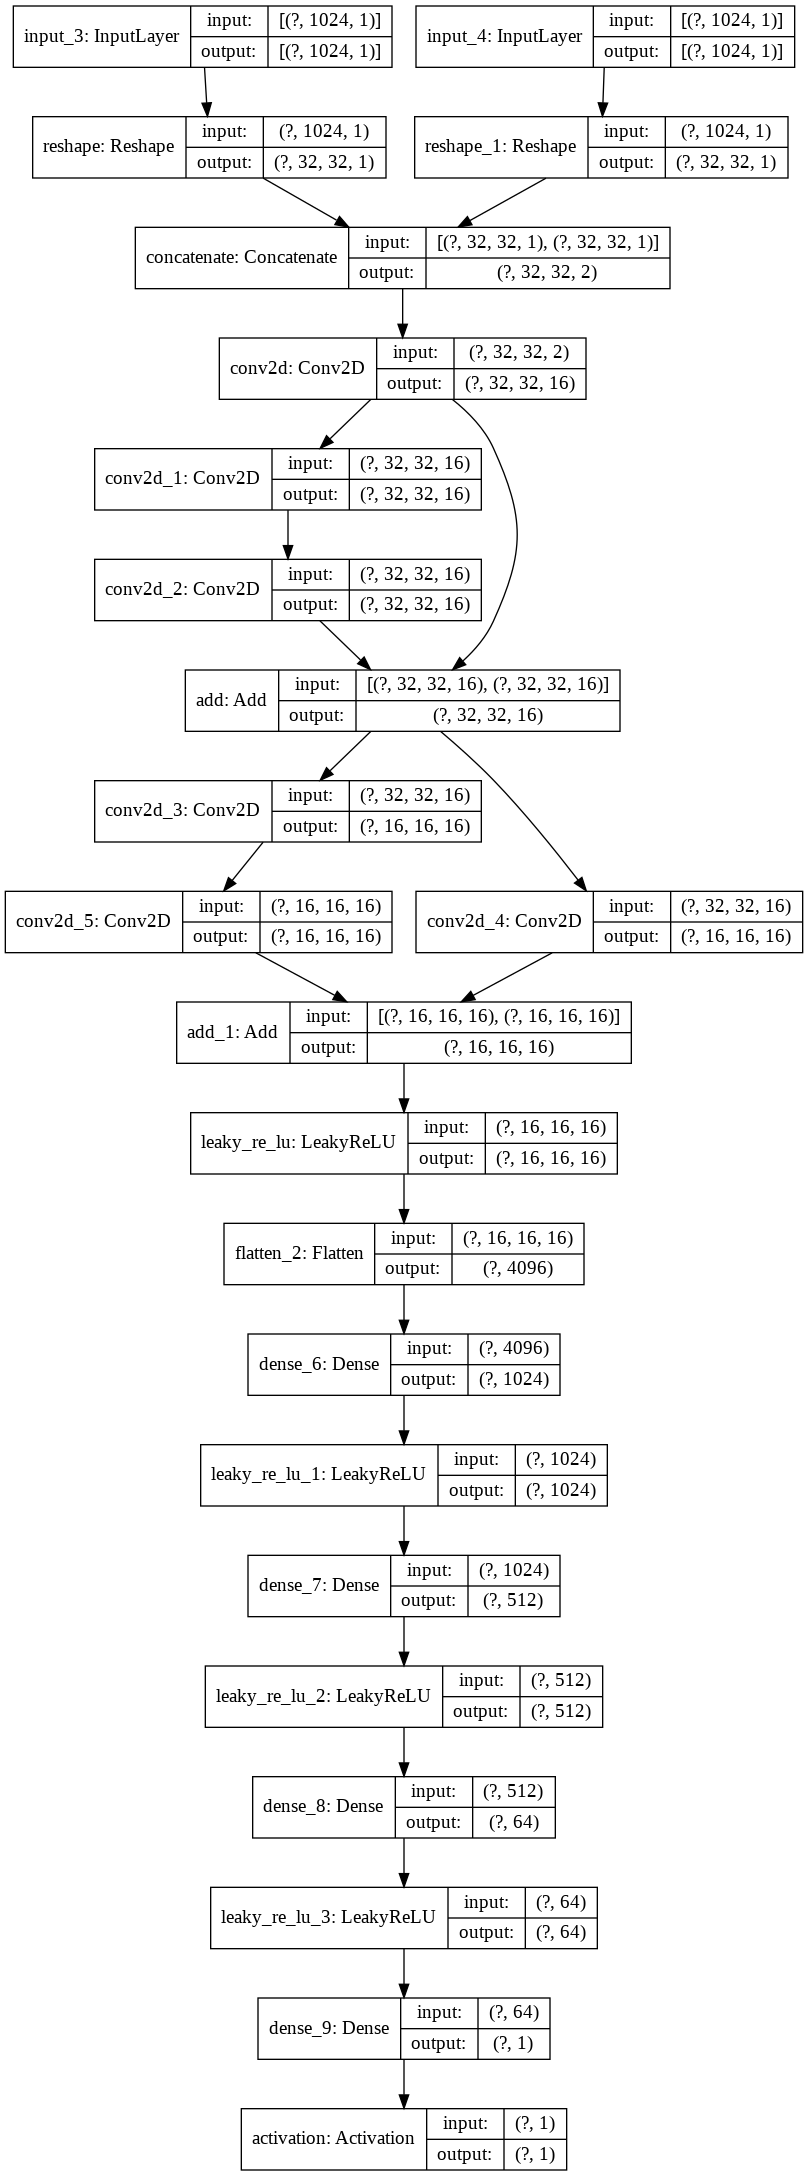

In [ ]:
plot_model(dml, show_shapes = True)

#### Training the DML

In [ ]:
dml_train_df = pd.read_csv('dml_train.csv')
dml_test_df = pd.read_csv('dml_test.csv')

In [ ]:
def compute_features():
    sat_imgs = glob('SatView/Images/**/*')
    str_imgs = glob('StreetView/Images/**/*')
    
    if not os.path.exists('SatView/Features'):
        os.mkdir('SatView/Features')
    if not os.path.exists('StreetView/Features'):
        os.mkdir('StreetView/Features')
    print("Computing for Satellite Images")
    for f in sat_imgs:
        img = get_image(f)
        base_path = 'SatView/Features/'
        filename = f.split('/')[-1].split('.')[0]
        ext = '.npy'
        fv = sat_fv_extractor.predict(np.expand_dims(img,axis=0)).reshape(1024,1)
        save_at = base_path + filename + ext
        if not os.path.exists(save_at):
            np.save(save_at,fv)
            
    print("Computing for Street Images")
    for f in str_imgs:
        img = get_image(f)
        base_path = 'StreetView/Features/'
        filename = f.split('/')[-1].split('.')[0]
        ext = '.npy'
        fv = str_fv_extractor.predict(np.expand_dims(img,axis=0)).reshape(1024,1)
        save_at = base_path + filename + ext
        if not os.path.exists(save_at):
            np.save(save_at,fv)

Create a Data Generator for training the DML

In [ ]:
def dml_data_generator(df, batch_size = 32, mode='train'):
    num_rows = df.shape[0]
    indexes = np.arange(0, num_rows, batch_size)
    if num_rows % batch_size != 0:
        indexes = indexes[:-1]
    # np.random.shuffle(indexes)
    
    while 1:

        for index in indexes:

            batch_start = index
            batch_end = index + batch_size

            sat_features = []
            str_features = []        
            labels = []

            for i in range(batch_start, batch_end):
                label = df.iloc[i]['label']
                labels.append(label)

                sat_path = df.iloc[i]['sat_path']
                sat_features.append(np.load(sat_path))

                str_path = df.iloc[i]['str_path']
                str_features.append(np.load(str_path))

            sat_features = np.array(sat_features)
            str_features = np.array(str_features)
            labels = np.array(labels).astype(np.float32).reshape(BATCH_SIZE, 1)


            yield ([sat_features, str_features], labels)

In [ ]:
dml_train_gen = dml_data_generator(dml_train_df,batch_size=BATCH_SIZE)
dml_test_gen = dml_data_generator(dml_test_df,batch_size=BATCH_SIZE)

Add callbacks

In [ ]:
# Callbacks for DML go here
checkpointer_dml = ModelCheckpoint(filepath='weights_dml.hdf5', monitor='val_loss',verbose=1, save_best_only=True, mode = 'auto')
dml_callbacks = [checkpointer_dml]

Training the model

In [ ]:
dml_hist = dml.fit_generator(generator=dml_train_gen,
    steps_per_epoch = dml_train_df.shape[0]//BATCH_SIZE,
    validation_data = dml_test_gen,
    validation_steps = dml_test_df.shape[0]//BATCH_SIZE,
    callbacks = dml_callbacks,
    epochs = 10)

Epoch 1/10
1050/1050 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.5576
Epoch 00001: val_loss improved from inf to 0.54540, saving model to weights_dml.hdf5
1050/1050 [==============================] - 74s 70ms/step - loss: 0.6680 - accuracy: 0.5576 - val_loss: 0.5454 - val_accuracy: 0.7227
Epoch 2/10
1050/1050 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.7562
Epoch 00002: val_loss improved from 0.54540 to 0.44981, saving model to weights_dml.hdf5
1050/1050 [==============================] - 74s 71ms/step - loss: 0.4932 - accuracy: 0.7562 - val_loss: 0.4498 - val_accuracy: 0.7954
Epoch 3/10
1050/1050 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8317
Epoch 00003: val_loss improved from 0.44981 to 0.37052, saving model to weights_dml.hdf5
1050/1050 [==============================] - 73s 70ms/step - loss: 0.3726 - accuracy: 0.8317 - val_loss: 0.3705 - val_accuracy: 0.8359
Epoch 4/10
1050/1050 [================

In [ ]:
dml.save_weights('dml_weights.h5')

#### Analysing the DML

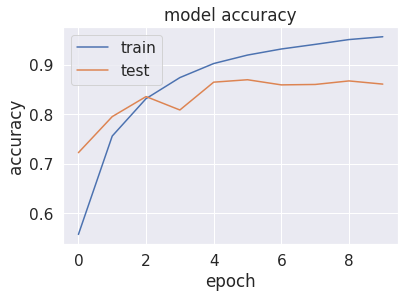

In [ ]:
plot_accuracy(dml_hist)

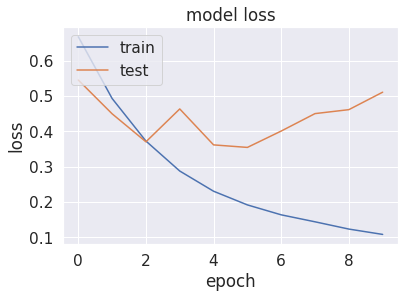

In [ ]:
plot_loss(dml_hist)

### Computing Similarity between Query Image and a Search Image

In [ ]:
def sort_by_value(dict_obj):
    return collections.OrderedDict(sorted(dict_obj.items(), key=lambda kv: kv[1]))

In [ ]:
def get_similar(query_fv_path,database,metric='dml',query_view='str',batch_size=32):
    results = {}
    query_fv = np.load(query_fv_path)
    opp_view = 'sat' if query_view == 'str' else 'str'
    opp_view_imgs = database[database['view']==opp_view]
    for i in opp_view_imgs.index:
        opp_view_fv = np.load(opp_view_imgs['fv_path'][i])
        if metric == 'dml':
            pred = np.squeeze(dml.predict([opp_view_fv.reshape((1,1024,1)), query_fv.reshape((1,1024,1))]))
        elif metric == 'cosine':
            pred = cosine(opp_view_fv, query_fv)
        else:
            print('Metric not recognized')
            return
        results[opp_view_imgs['img_path'][i]] = pred

    return sort_by_value(results)

## 4 Image Retrieval


In [ ]:
def view_results(results_dict,n=5):
    fig = figure(figsize=(15,15))
    files = list(results_dict.keys())
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        image = imread(files[i])
        imshow(image)
        axis('off')
    plt.show()

In [ ]:
def get_db(df,imgs_per_classes=5):
    classes = ['freeway','mountain','palace','river','ship', 'stadium']
    sat_df = df[df['view'] == 'sat']
    str_df = df[df['view'] == 'str']
    db = pd.DataFrame({},columns=df.columns)
    for c in classes:
        sat_sample = sat_df[sat_df['class'] == c].sample(imgs_per_classes,random_state=ROLLNUMBER)
        str_sample = str_df[str_df['class'] == c].sample(imgs_per_classes,random_state=ROLLNUMBER)
        db = pd.concat([db,sat_sample,str_sample])
    return db.sample(frac=1,random_state=ROLLNUMBER).reset_index(drop=True)

In [ ]:
full_database = pd.read_csv('Retrieval_Database.csv')

In [ ]:
database = get_db(full_database,imgs_per_classes=5)

In [ ]:
def view_img(img_path):
    # a=fig.add_subplot(1,n,i+1)
    image = imread(img_path)
    axis('off')
    imshow(image)
    plt.show()


In [ ]:
def search(query_fv_path,database,dist_metric='dml',num_results=5):
    results = get_similar(query_fv_path, database, metric=dist_metric, query_view='str')
    top = list(results.keys())[:num_results]
    return {k:results[k] for k in top}

In [ ]:
def generate_query_imgs():
    classes = list(labels_dict.keys())
    query_imgs = {}
    for c in classes:
        subdb = database[database['class']==c][database['view']=='str'].sample(1)
        img_path = subdb['img_path'].iloc[0]
        fv_path = subdb['fv_path'].iloc[0]
        query_imgs[c] = {'img_path': img_path, 'fv_path': fv_path}
    return query_imgs

def evaluate(query_imgs, metric = 'dml'):
    for cl,val in query_imgs.items():
        view_img(val['img_path'])
        res = search(val['fv_path'], database, dist_metric = metric)
        view_results(res)


In [ ]:
queries = generate_query_imgs()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


##### Using Cosine Distance

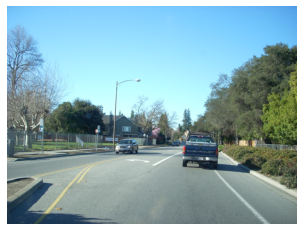

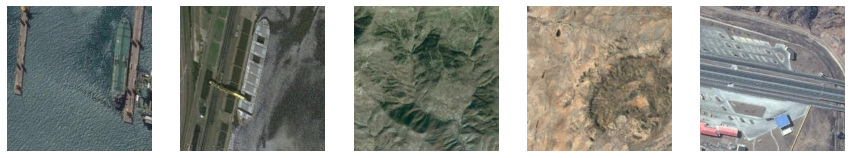

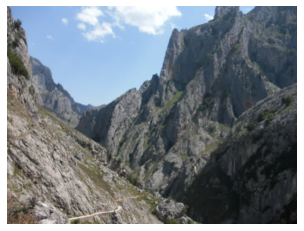

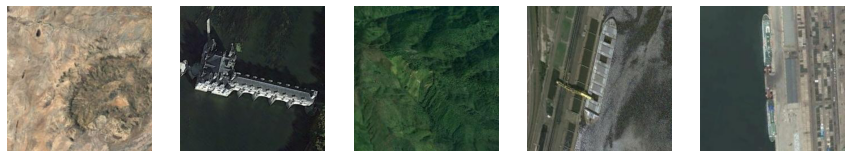

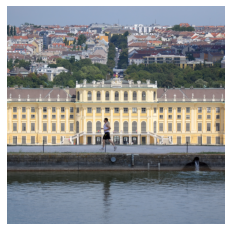

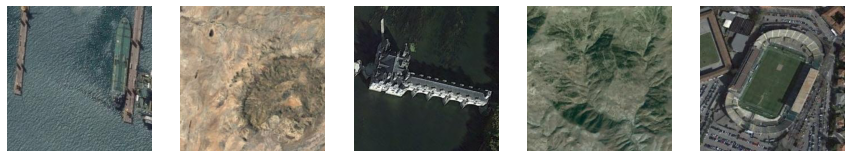

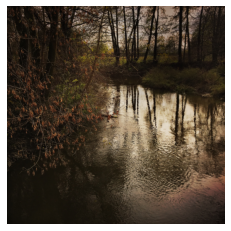

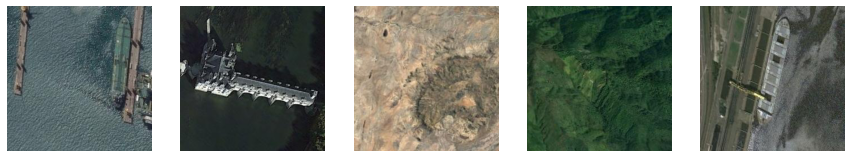

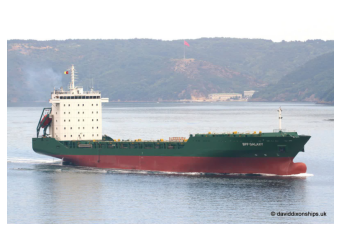

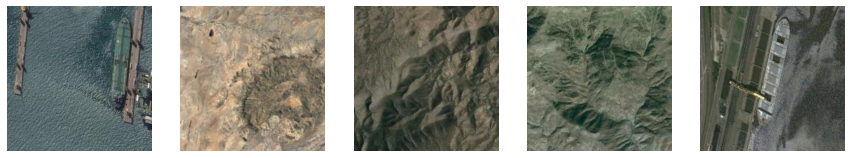

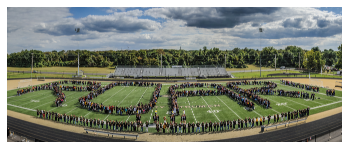

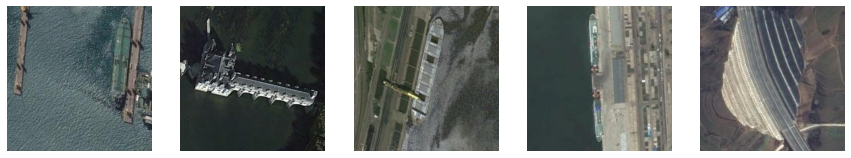

In [ ]:
evaluate(queries, metric='cosine')

##### Using the DML

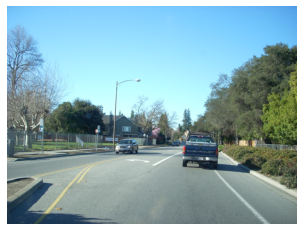

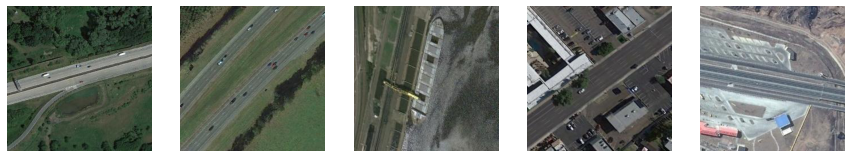

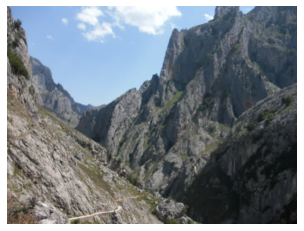

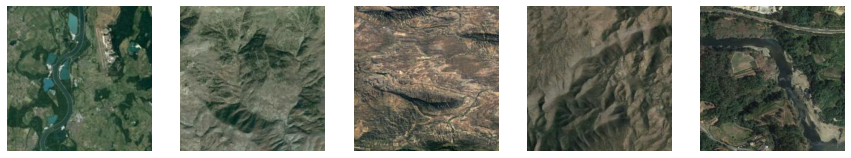

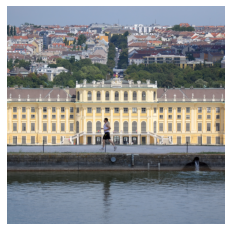

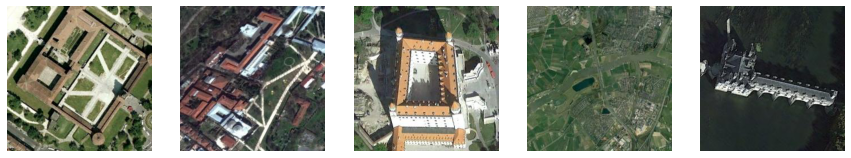

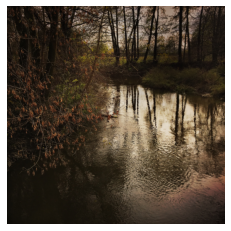

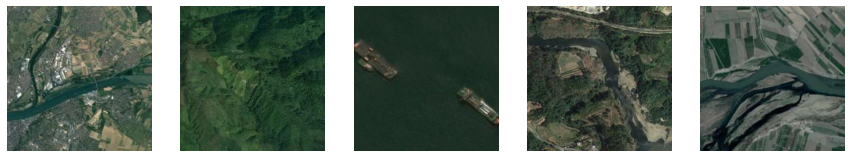

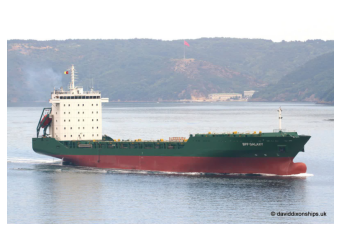

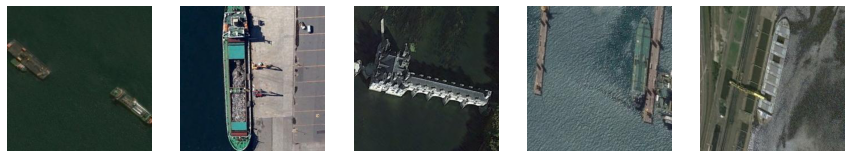

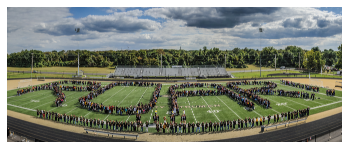

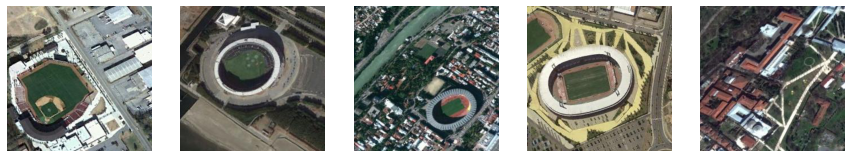

In [ ]:
evaluate(queries, metric='dml')